In [34]:
import pandas as pd

RF_path = "../data/red_fox.csv"
red_fox = pd.read_csv(RF_path)
print(red_fox.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12840 entries, 0 to 12839
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   event-id                         12840 non-null  int64  
 1   visible                          12840 non-null  bool   
 2   timestamp                        12840 non-null  object 
 3   location-long                    12840 non-null  float64
 4   location-lat                     12840 non-null  float64
 5   gps:fix-type                     12840 non-null  int64  
 6   gps:fix-type-raw                 12840 non-null  object 
 7   gps:hdop                         12840 non-null  float64
 8   gps:satellite-count              12840 non-null  int64  
 9   sensor-type                      12840 non-null  object 
 10  individual-taxon-canonical-name  12840 non-null  object 
 11  tag-local-identifier             12840 non-null  object 
 12  individual-local-i

In [35]:
grouped = red_fox.groupby('tag-local-identifier')
# print(grouped.size())

In [66]:
# create dataframe only containing tag-local-identifier of F701532 and F701533
# red_fox_2 = red_fox[red_fox['tag-local-identifier'].isin(['F701532', 'F701533'])]
red_fox_F701533 = red_fox[red_fox['tag-local-identifier'].isin(['F701533'])]
red_fox_F701532 = red_fox[red_fox['tag-local-identifier'].isin(['F701532'])]
# print(red_fox_F701533.info())

In [67]:
# get rid of columns other than timestamp, location-long, location-lat
red_fox_F701533 = red_fox_F701533[['timestamp', 'location-long', 'location-lat']]
red_fox_F701532 = red_fox_F701532[['timestamp', 'location-long', 'location-lat']]
# red_fox_F701533 = red_fox[['timestamp', 'location-long', 'location-lat']]
print(red_fox_F701533.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1944 entries, 214 to 2157
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestamp      1944 non-null   object 
 1   location-long  1944 non-null   float64
 2   location-lat   1944 non-null   float64
dtypes: float64(2), object(1)
memory usage: 60.8+ KB
None


## General Information 
 Calculate some general information of the total distance (in meters) moved and average moving speed (in meters/day)



In [38]:
# write functions to get the total distance trtaveled and average speed 
# timestamp in formate 2017-05-10 00:00:00.000

data_analyse = red_fox_F701533.copy()

def total_distance(df):
    """
    This function calculates the total distance traveled by the animal in meters
    """
    distance = 0
    for i in range(1, len(df)):
        distance += ((df.iloc[i]['location-long'] - df.iloc[i-1]['location-long'])**2 + (df.iloc[i]['location-lat'] - df.iloc[i-1]['location-lat'])**2)**0.5

    # change the distance into meters
    return distance * 111139

def average_speed_per_day(df):
    """
    This function calculates the average speed of the animal in m/day
    """
    distance = total_distance(df)

    time = (pd.to_datetime(df.iloc[-1]['timestamp']) - pd.to_datetime(df.iloc[0]['timestamp'])).days
    print(time)

    return distance / time

print(total_distance(data_analyse))
print(average_speed_per_day(data_analyse))

2216252.6113582454
432
5130.214378144086


In [39]:
# pip install geopy

In [40]:
import pandas as pd
from geopy.distance import geodesic

def calculate_average_distance_auto_sections(df, interval_minutes=90):
    """
    Calculate the average distance moved for each automatically derived section of the day.

    Args:
        df (pd.DataFrame): DataFrame containing 'timestamp', 'location-lat', 'location-long' columns.
        interval_minutes (int): The interval in minutes for grouping timestamps.

    Returns:
        pd.DataFrame: A DataFrame with sections and average distances.
    """
    # Ensure the timestamp is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Sort the data by timestamp
    df = df.sort_values(by='timestamp')
    
    # Calculate distances between consecutive points
    def compute_distance(row):
        if pd.isna(row['prev_lat']) or pd.isna(row['prev_long']):
            return 0
        return geodesic((row['prev_lat'], row['prev_long']), (row['location-lat'], row['location-long'])).meters

    df['prev_lat'] = df['location-lat'].shift()
    df['prev_long'] = df['location-long'].shift()
    df['distance'] = df.apply(compute_distance, axis=1)
    
    # Create sections based on intervals
    df['section'] = (df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute) // interval_minutes
    
    # Calculate the average distance for each section
    avg_distances = (
        df.groupby(['section'])['distance']
        .mean()
        .reset_index()
        .rename(columns={'distance': 'avg_distance'})
    )
    
    # Add section labels for clarity
    avg_distances['section_label'] = avg_distances['section'].apply(
        lambda x: f"{(x * interval_minutes) // 60:02d}:{(x * interval_minutes) % 60:02d} to "
                  f"{((x + 1) * interval_minutes) // 60:02d}:{((x + 1) * interval_minutes) % 60:02d}"
    )
    
    return avg_distances

# Example usage
# Assuming `data_analyse` is your DataFrame with 'timestamp', 'location-lat', and 'location-long'
average_distances = calculate_average_distance_auto_sections(data_analyse)

# Display the result
print(average_distances)




    section  avg_distance   section_label
0         0    366.590668  00:00 to 01:30
1         1    660.469329  01:30 to 03:00
2         2   1123.798310  03:00 to 04:30
3         3   1549.233416  04:30 to 06:00
4         4   1645.849371  06:00 to 07:30
5         5   1330.589034  07:30 to 09:00
6         6   1041.961249  09:00 to 10:30
7         7    592.112939  10:30 to 12:00
8         8    720.078290  12:00 to 13:30
9         9    583.750050  13:30 to 15:00
10       10    743.533219  15:00 to 16:30
11       11    799.131003  16:30 to 18:00
12       12    638.141142  18:00 to 19:30
13       13    508.650460  19:30 to 21:00
14       14    383.259631  21:00 to 22:30
15       15    351.023782  22:30 to 24:00


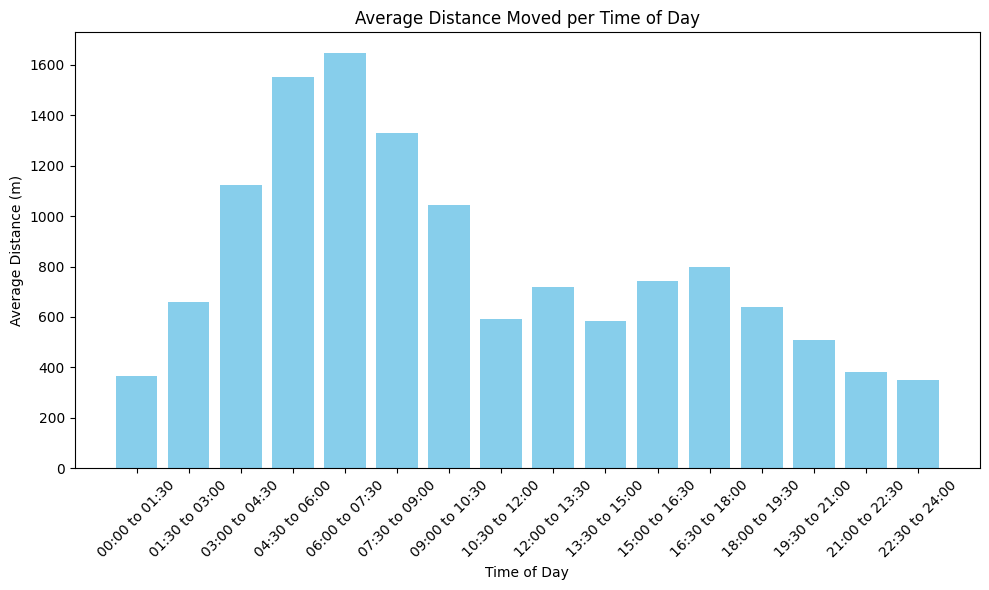

In [41]:
# visualize the result
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(average_distances['section_label'], average_distances['avg_distance'], color='skyblue')
plt.xticks(rotation=45)
plt.ylabel('Average Distance (m)')
plt.xlabel('Time of Day')
plt.title('Average Distance Moved per Time of Day')
plt.tight_layout()
plt.show()

In [42]:
def calculate_total_distance_per_day_per_month(df):
    """
    Calculate the total moving distance per day and aggregate it by month.

    Args:
        df (pd.DataFrame): DataFrame containing 'timestamp', 'location-lat', 'location-long' columns.

    Returns:
        pd.DataFrame: A DataFrame with months and the average daily total distance.
    """
    # Ensure the timestamp is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Sort the data by timestamp
    df = df.sort_values(by='timestamp')
    
    # Calculate distances between consecutive points
    def compute_distance(row):
        if pd.isna(row['prev_lat']) or pd.isna(row['prev_long']):
            return 0
        return geodesic((row['prev_lat'], row['prev_long']), (row['location-lat'], row['location-long'])).meters

    df['prev_lat'] = df['location-lat'].shift()
    df['prev_long'] = df['location-long'].shift()
    df['distance'] = df.apply(compute_distance, axis=1)
    
    # Extract the day and month from the timestamp
    df['day'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.to_period('M')
    
    # Calculate total distance per day
    daily_total = (
        df.groupby(['day'])['distance']
        .sum()
        .reset_index()
        .rename(columns={'distance': 'total_distance_per_day'})
    )
    
    # Aggregate by month to get the average daily total distance
    monthly_avg = (
        daily_total.groupby(daily_total['day'].apply(lambda x: x.strftime('%Y-%m')))['total_distance_per_day']
        .mean()
        .reset_index()
        .rename(columns={'day': 'month', 'total_distance_per_day': 'avg_daily_total_distance'})
    )
    
    return monthly_avg

# Example usage
# Assuming `data_analyse` is your DataFrame with 'timestamp', 'location-lat', and 'location-long'
monthly_avg_distances = calculate_total_distance_per_day_per_month(data_analyse)

# Display the result
print(monthly_avg_distances)

     month  avg_daily_total_distance
0  2019-04               8641.066251
1  2019-05               9151.372066
2  2019-06              14050.698699
3  2020-03              10531.110730
4  2020-04               9061.684887
5  2020-05               9539.675391
6  2020-06              14187.531656


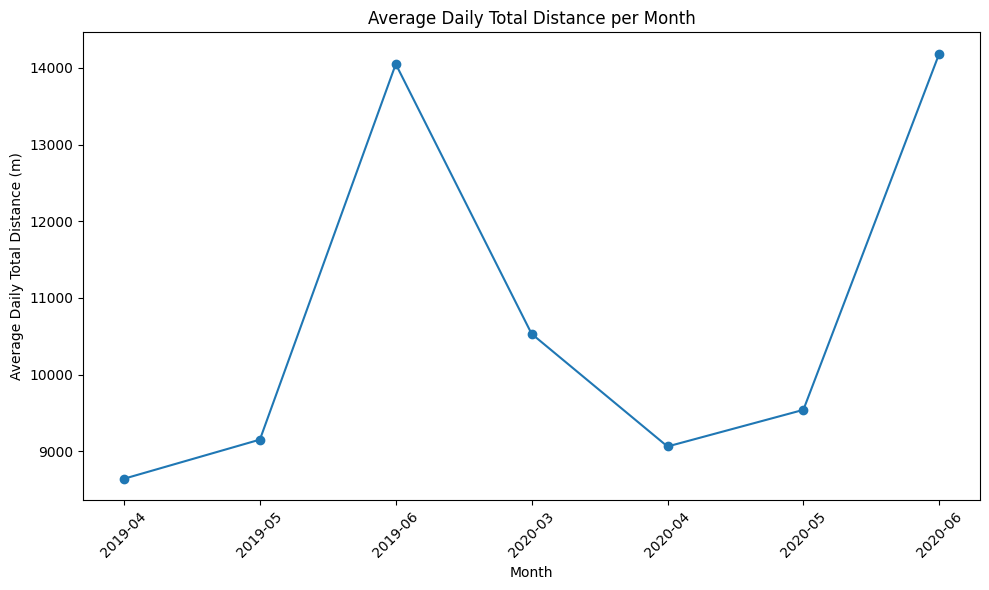

In [43]:
# visualize the result
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_distances['month'], monthly_avg_distances['avg_daily_total_distance'], marker='o')
plt.xticks(rotation=45)
plt.ylabel('Average Daily Total Distance (m)')
plt.xlabel('Month')
plt.title('Average Daily Total Distance per Month')
plt.tight_layout()
plt.show()



In [44]:
import pandas as pd
import numpy as np

def calculate_moving_directions(df, interval_minutes=90):
    """
    Calculate the moving directions of an animal at each time section.

    Args:
        df (pd.DataFrame): DataFrame containing 'timestamp', 'location-lat', 'location-long' columns.
        interval_minutes (int): Interval in minutes to define sections.

    Returns:
        pd.DataFrame: A DataFrame with sections and predominant moving directions.
    """
    # Ensure the timestamp is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Sort the data by timestamp
    df = df.sort_values(by='timestamp')
    
    # Calculate bearings (directions) between consecutive points
    def calculate_bearing(lat1, lon1, lat2, lon2):
        # Convert degrees to radians
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        d_lon = lon2 - lon1
        x = np.sin(d_lon) * np.cos(lat2)
        y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_lon)
        initial_bearing = np.arctan2(x, y)
        initial_bearing = np.degrees(initial_bearing)
        return (initial_bearing + 360) % 360  # Normalize to 0-360 degrees

    df['prev_lat'] = df['location-lat'].shift()
    df['prev_long'] = df['location-long'].shift()
    df['bearing'] = df.apply(
        lambda row: calculate_bearing(row['prev_lat'], row['prev_long'], row['location-lat'], row['location-long'])
        if not pd.isna(row['prev_lat']) else None, axis=1
    )
    
    # Assign sections based on intervals
    df['section'] = (df['timestamp'].dt.hour * 60 + df['timestamp'].dt.minute) // interval_minutes
    
    # Map bearings to cardinal directions
    def bearing_to_direction(bearing):
        directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
        index = int((bearing + 22.5) // 45) % 8
        return directions[index]

    df['direction'] = df['bearing'].apply(lambda x: bearing_to_direction(x) if not pd.isna(x) else None)
    
    # Analyze predominant direction in each section
    predominant_directions = (
        df.groupby(['section'])['direction']
        .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
        .reset_index()
        .rename(columns={'direction': 'predominant_direction'})
    )
    
    # Add section labels for clarity
    predominant_directions['section_label'] = predominant_directions['section'].apply(
        lambda x: f"{(x * interval_minutes) // 60:02d}:{(x * interval_minutes) % 60:02d} to "
                  f"{((x + 1) * interval_minutes) // 60:02d}:{((x + 1) * interval_minutes) % 60:02d}"
    )
    
    return predominant_directions

# Example usage
# Assuming `data_analyse` is your DataFrame with 'timestamp', 'location-lat', and 'location-long'
directions_analysis = calculate_moving_directions(data_analyse)

# Display the result
print(directions_analysis)


    section predominant_direction   section_label
0         0                    SE  00:00 to 01:30
1         1                    NE  01:30 to 03:00
2         2                     N  03:00 to 04:30
3         3                     N  04:30 to 06:00
4         4                    NW  06:00 to 07:30
5         5                     N  07:30 to 09:00
6         6                     W  09:00 to 10:30
7         7                     S  10:30 to 12:00
8         8                     S  12:00 to 13:30
9         9                    SE  13:30 to 15:00
10       10                     S  15:00 to 16:30
11       11                     S  16:30 to 18:00
12       12                    SE  18:00 to 19:30
13       13                    SE  19:30 to 21:00
14       14                    SW  21:00 to 22:30
15       15                    NE  22:30 to 24:00


In [45]:
import pandas as pd
from geopy.distance import geodesic
import numpy as np

def calculate_monthly_distance_and_direction(df):
    """
    Calculate the total moving distance and direction for each month by comparing
    the start location of the month to the end location.

    Args:
        df (pd.DataFrame): DataFrame containing 'timestamp', 'location-lat', 'location-long' columns.

    Returns:
        pd.DataFrame: A DataFrame with months, total distance, and direction.
    """
    # Ensure the timestamp is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Extract month from timestamp
    df['month'] = df['timestamp'].dt.to_period('M')
    
    # Sort by timestamp
    df = df.sort_values(by='timestamp')
    
    # Get the first and last location for each month
    monthly_locations = df.groupby('month').agg(
        start_lat=('location-lat', 'first'),
        start_long=('location-long', 'first'),
        end_lat=('location-lat', 'last'),
        end_long=('location-long', 'last')
    ).reset_index()
    
    # Calculate distance and bearing between start and end locations
    def calculate_distance_and_bearing(row):
        start = (row['start_lat'], row['start_long'])
        end = (row['end_lat'], row['end_long'])
        distance = geodesic(start, end).meters
        
        # Calculate bearing
        def calculate_bearing(lat1, lon1, lat2, lon2):
            # Convert degrees to radians
            lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
            d_lon = lon2 - lon1
            x = np.sin(d_lon) * np.cos(lat2)
            y = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(d_lon)
            initial_bearing = np.arctan2(x, y)
            initial_bearing = np.degrees(initial_bearing)
            return (initial_bearing + 360) % 360  # Normalize to 0-360 degrees

        bearing = calculate_bearing(row['start_lat'], row['start_long'], row['end_lat'], row['end_long'])
        
        return pd.Series({'total_distance': distance, 'bearing': bearing})
    
    # Apply the distance and bearing calculation
    monthly_locations[['total_distance', 'bearing']] = monthly_locations.apply(
        calculate_distance_and_bearing, axis=1
    )
    
    # Map bearings to cardinal directions
    def bearing_to_direction(bearing):
        directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW']
        index = int((bearing + 22.5) // 45) % 8
        return directions[index]
    
    monthly_locations['direction'] = monthly_locations['bearing'].apply(bearing_to_direction)
    
    # Select relevant columns
    result = monthly_locations[['month', 'total_distance', 'direction']]
    
    return result

# Example usage
# Assuming `data_analyse` is your DataFrame with 'timestamp', 'location-lat', and 'location-long'
monthly_distance_and_direction = calculate_monthly_distance_and_direction(data_analyse)

# Display the result
print(monthly_distance_and_direction)


     month  total_distance direction
0  2019-04     3797.490068        SW
1  2019-05     6032.498268        NW
2  2019-06      727.346543        SW
3  2020-03      549.751299         W
4  2020-04     4027.881209        NE
5  2020-05     3430.484032         W
6  2020-06     6226.357731         S


In [46]:
# get the most frequent area of the animal
import pandas as pd
from sklearn.cluster import KMeans

def calculate_frequent_areas(df, num_clusters=5):
    """
    This function calculates the most frequent areas visited by an animal.

    Args:
        df (pd.DataFrame): DataFrame containing 'timestamp', 'location-lat', and 'location-long' columns.
        num_clusters (int): Number of clusters to use for KMeans clustering.

    Returns:
        pd.DataFrame: A DataFrame with the most frequent areas and their frequencies.

    """
    # Ensure the timestamp is in datetime format
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Sort the data by timestamp
    df = df.sort_values(by='timestamp')
    
    # Extract the latitude and longitude columns
    X = df[['location-lat', 'location-long']]
    
    # Fit a KMeans clustering model
    kmeans = KMeans(n_clusters=num_clusters, random_state=0).fit(X)
    
    # Assign cluster labels to each point
    df['cluster'] = kmeans.predict(X)
    
    # Calculate the frequency of each cluster
    frequent_areas = (
        df.groupby('cluster')
        .size()
        .reset_index(name='frequency')
        .sort_values(by='frequency', ascending=False)
    )
    
    # Get the cluster centers
    cluster_centers = kmeans.cluster_centers_
    
    # Add cluster centers to the frequent areas DataFrame
    frequent_areas['location-lat'] = frequent_areas['cluster'].apply(lambda x: cluster_centers[x][0])
    frequent_areas['location-long'] = frequent_areas['cluster'].apply(lambda x: cluster_centers[x][1])
    
    # Calculate the most frequent time for each cluster appearance
    frequent_times = (
        df.groupby('cluster')['timestamp']
        .apply(lambda x: x.dt.hour.mode()[0] if not x.dt.hour.mode().empty else None)
        .reset_index(name='most_frequent_hour')
    )
    
    # Merge the frequent times with the frequent areas DataFrame
    frequent_areas = frequent_areas.merge(frequent_times, on='cluster')
    
    return frequent_areas

# Example usage
# Assuming `data_analyse` is your DataFrame with 'timestamp', 'location-lat', and 'location-long'
frequent_areas = calculate_frequent_areas(data_analyse, 5)
print(frequent_areas)


   cluster  frequency  location-lat  location-long  most_frequent_hour
0        2        658     57.951732     -92.935670                   4
1        1        507     57.872984     -92.869947                  19
2        4        441     57.880238     -92.933876                  18
3        3        179     57.912628     -92.928188                   6
4        0        159     57.896647     -92.965259                   6


In [48]:
import pandas as pd
from geopy.distance import geodesic

def calculate_distance_stats_between_foxes(fox_df1, fox_df2):
    """
    Calculate the average, longest, and shortest distance between two foxes.

    Args:
        fox_df1 (pd.DataFrame): DataFrame containing data for the first fox with 'timestamp', 'location-lat', 'location-long' columns.
        fox_df2 (pd.DataFrame): DataFrame containing data for the second fox with 'timestamp', 'location-lat', 'location-long' columns.

    Returns:
        dict: A dictionary with the average, longest, and shortest distance.
    """
    # Ensure the timestamp is in datetime format
    fox_df1['timestamp'] = pd.to_datetime(fox_df1['timestamp'])
    fox_df2['timestamp'] = pd.to_datetime(fox_df2['timestamp'])
    
    # Merge the two DataFrames on the nearest timestamps
    merged = pd.merge_asof(
        fox_df1.sort_values(by='timestamp'),
        fox_df2.sort_values(by='timestamp'),
        on='timestamp',
        suffixes=('_fox1', '_fox2'),
        direction='nearest'  # Match the closest timestamp
    )
    
    # Calculate the distance between the two foxes
    def calculate_distance(row):
        fox1_location = (row['location-lat_fox1'], row['location-long_fox1'])
        fox2_location = (row['location-lat_fox2'], row['location-long_fox2'])
        return geodesic(fox1_location, fox2_location).meters

    merged['distance'] = merged.apply(calculate_distance, axis=1)
    
    # Compute statistics
    average_distance = merged['distance'].mean()
    longest_distance = merged['distance'].max()
    shortest_distance = merged['distance'].min()
    
    # Return the results as a dictionary
    return {
        'average_distance': average_distance,
        'longest_distance': longest_distance,
        'shortest_distance': shortest_distance
    }

# Example usage
# Assuming `fox1_df` and `fox2_df` are your DataFrames with 'timestamp', 'location-lat', and 'location-long'
distance_stats = calculate_distance_stats_between_foxes(red_fox_F701533, red_fox_F701532)

# Display the result
print(distance_stats)


{'average_distance': 12417.661153578189, 'longest_distance': 22381.470807564758, 'shortest_distance': 3207.8021833089733}


In [49]:
import pandas as pd
from geopy.distance import geodesic

def calculate_monthly_average_distance_between_foxes(fox_df1, fox_df2):
    """
    Calculate the average distance between two foxes for each month.

    Args:
        fox_df1 (pd.DataFrame): DataFrame containing data for the first fox with 'timestamp', 'location-lat', 'location-long' columns.
        fox_df2 (pd.DataFrame): DataFrame containing data for the second fox with 'timestamp', 'location-lat', 'location-long' columns.

    Returns:
        pd.DataFrame: A DataFrame with each month and the corresponding average distance.
    """
    # Ensure the timestamp is in datetime format
    fox_df1['timestamp'] = pd.to_datetime(fox_df1['timestamp'])
    fox_df2['timestamp'] = pd.to_datetime(fox_df2['timestamp'])
    
    # Merge the two DataFrames on the nearest timestamps
    merged = pd.merge_asof(
        fox_df1.sort_values(by='timestamp'),
        fox_df2.sort_values(by='timestamp'),
        on='timestamp',
        suffixes=('_fox1', '_fox2'),
        direction='nearest'  # Match the closest timestamp
    )
    
    # Calculate the distance between the two foxes
    def calculate_distance(row):
        fox1_location = (row['location-lat_fox1'], row['location-long_fox1'])
        fox2_location = (row['location-lat_fox2'], row['location-long_fox2'])
        return geodesic(fox1_location, fox2_location).meters

    merged['distance'] = merged.apply(calculate_distance, axis=1)
    
    # Extract the month from the timestamp
    merged['month'] = merged['timestamp'].dt.to_period('M')
    
    # Calculate the average distance for each month
    monthly_avg_distance = merged.groupby('month')['distance'].mean().reset_index()
    monthly_avg_distance.rename(columns={'distance': 'average_distance'}, inplace=True)
    
    return monthly_avg_distance

# Example usage
# Assuming `fox1_df` and `fox2_df` are your DataFrames with 'timestamp', 'location-lat', and 'location-long'
monthly_distance_stats = calculate_monthly_average_distance_between_foxes(red_fox_F701533, red_fox_F701532)

# Display the result
print(monthly_distance_stats)


     month  average_distance
0  2019-04       7915.053961
1  2019-05      13968.160879
2  2019-06      12136.499747
3  2020-03      13034.761528
4  2020-04      12609.164114
5  2020-05      14807.456465
6  2020-06      13080.291674


In [54]:
print(red_fox_F701532[:3])

               timestamp  location-long  location-lat  section         day
6094 2019-04-11 00:00:00     -92.801790     57.809658        0  2019-04-11
6095 2019-04-11 01:30:00     -92.801957     57.809605        1  2019-04-11
6096 2019-04-11 03:00:00     -92.801922     57.809652        2  2019-04-11


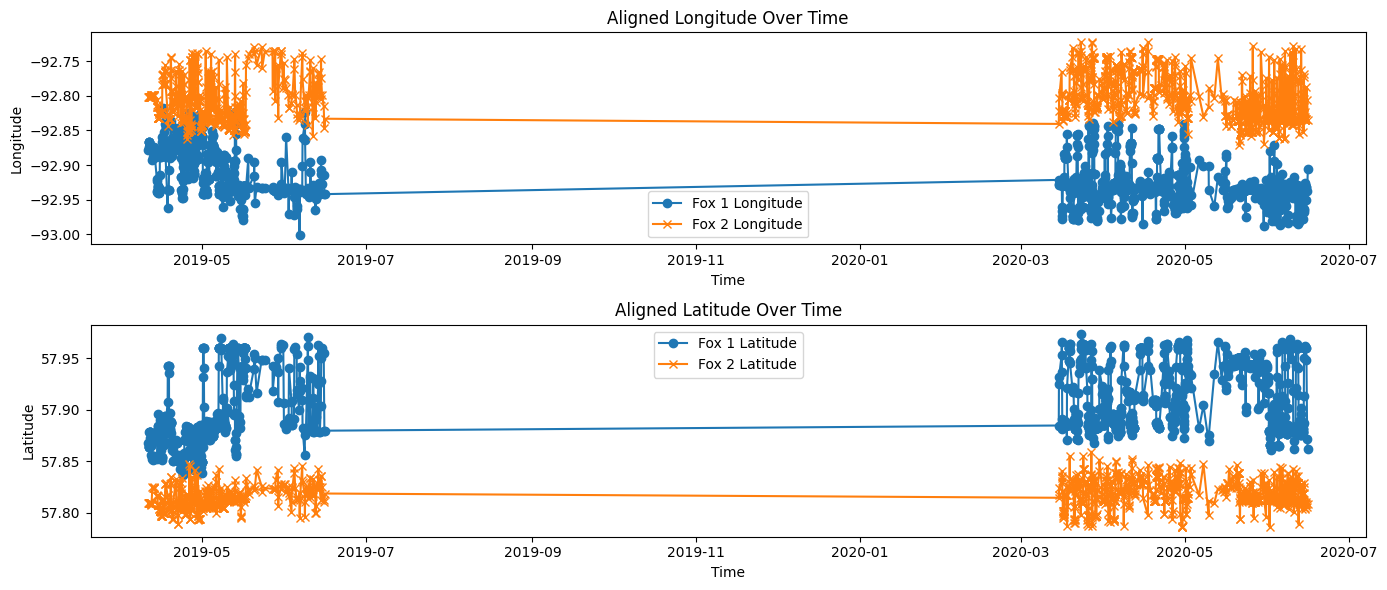

{'pearson_corr_long': 0.12159727699890499, 'pearson_corr_lat': 0.22996689895757758}


In [63]:
import numpy as np
import pandas as pd
from scipy.stats import pearsonr
from scipy.signal import correlate
import matplotlib.pyplot as plt

def analyze_fox_correlation_aligned(df1, df2):
    """
    Analyze the correlation between the movement patterns of two foxes based on longitude and latitude,
    aligning data points by timestamp.

    Parameters:
        df1 (pd.DataFrame): DataFrame with 'timestamp', 'location-long', and 'location-lat' for Fox 1.
        df2 (pd.DataFrame): DataFrame with 'timestamp', 'location-long', and 'location-lat' for Fox 2.

    Returns:
        dict: Pearson correlations for longitude and latitude after alignment.
    """
    # Merge DataFrames on timestamp
    merged_df = pd.merge(df1, df2, on='timestamp', suffixes=('_fox1', '_fox2'))
    
    # Extract aligned data
    time = pd.to_datetime(merged_df['timestamp'])
    fox1_long = merged_df['location-long_fox1'].values
    fox1_lat = merged_df['location-lat_fox1'].values
    fox2_long = merged_df['location-long_fox2'].values
    fox2_lat = merged_df['location-lat_fox2'].values

    # Pearson correlation for longitude and latitude
    corr_long, _ = pearsonr(fox1_long, fox2_long)
    corr_lat, _ = pearsonr(fox1_lat, fox2_lat)

    # Plot aligned trajectories
    plt.figure(figsize=(14, 6))
    
    # Longitude comparison
    plt.subplot(2, 1, 1)
    plt.plot(time, fox1_long, label='Fox 1 Longitude', marker='o')
    plt.plot(time, fox2_long, label='Fox 2 Longitude', marker='x')
    plt.xlabel('Time')
    plt.ylabel('Longitude')
    plt.title('Aligned Longitude Over Time')
    plt.legend()

    # Latitude comparison
    plt.subplot(2, 1, 2)
    plt.plot(time, fox1_lat, label='Fox 1 Latitude', marker='o')
    plt.plot(time, fox2_lat, label='Fox 2 Latitude', marker='x')
    plt.xlabel('Time')
    plt.ylabel('Latitude')
    plt.title('Aligned Latitude Over Time')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Return Pearson correlation results
    return {
        'pearson_corr_long': corr_long,
        'pearson_corr_lat': corr_lat,
    }




# Example usage
# Assuming `fox1_df` and `fox2_df` are your DataFrames with 'time', 'x', and 'y'
movement_correlation = analyze_fox_correlation_aligned(red_fox_F701533, red_fox_F701532)
print(movement_correlation)


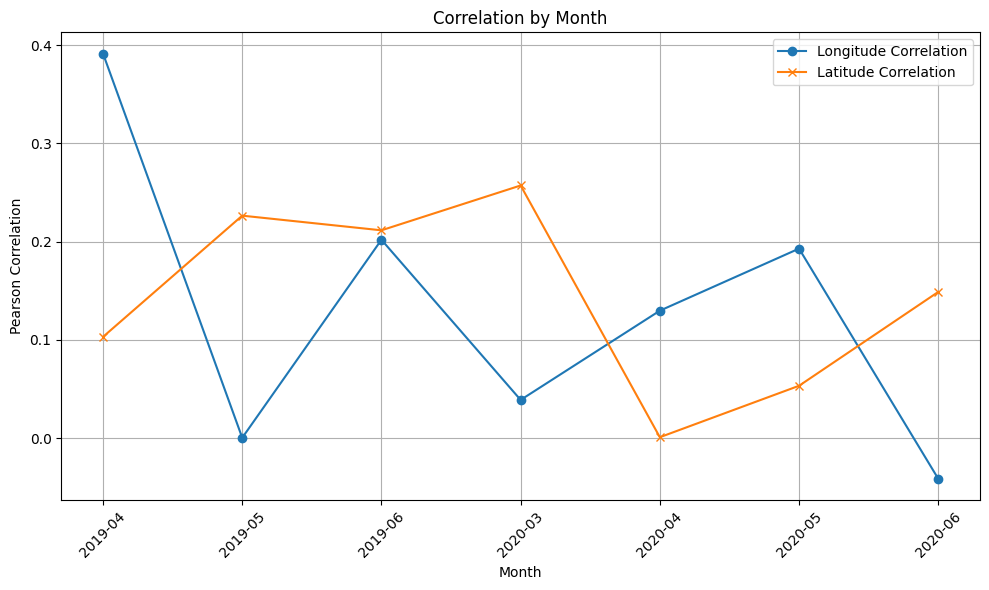

     month  pearson_corr_long  pearson_corr_lat
0  2019-04           0.391269          0.103119
1  2019-05           0.000432          0.226399
2  2019-06           0.201877          0.211487
3  2020-03           0.038942          0.257091
4  2020-04           0.129719          0.000995
5  2020-05           0.192866          0.053323
6  2020-06          -0.041232          0.148798


In [64]:
def analyze_fox_correlation_by_month(df1, df2):
    """
    Analyze the correlation between two foxes' movement patterns by month,
    aligning data points by timestamp.

    Parameters:
        df1 (pd.DataFrame): DataFrame with 'timestamp', 'location-long', and 'location-lat' for Fox 1.
        df2 (pd.DataFrame): DataFrame with 'timestamp', 'location-long', and 'location-lat' for Fox 2.

    Returns:
        pd.DataFrame: Correlation results (longitude and latitude) grouped by month.
    """
    # Convert timestamps to datetime objects
    df1['timestamp'] = pd.to_datetime(df1['timestamp'])
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])

    # Add month column for grouping
    df1['month'] = df1['timestamp'].dt.to_period('M')
    df2['month'] = df2['timestamp'].dt.to_period('M')

    # Merge DataFrames on timestamp
    merged_df = pd.merge(df1, df2, on='timestamp', suffixes=('_fox1', '_fox2'))
    merged_df['month'] = merged_df['timestamp'].dt.to_period('M')

    # Group by month and calculate Pearson correlations
    results = []
    for month, group in merged_df.groupby('month'):
        fox1_long = group['location-long_fox1'].values
        fox1_lat = group['location-lat_fox1'].values
        fox2_long = group['location-long_fox2'].values
        fox2_lat = group['location-lat_fox2'].values

        if len(fox1_long) > 1:  # Pearson correlation requires at least 2 points
            corr_long, _ = pearsonr(fox1_long, fox2_long)
            corr_lat, _ = pearsonr(fox1_lat, fox2_lat)
        else:
            corr_long, corr_lat = np.nan, np.nan  # Not enough data for correlation

        results.append({'month': month, 'pearson_corr_long': corr_long, 'pearson_corr_lat': corr_lat})

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Plot correlations by month
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['month'].astype(str), results_df['pearson_corr_long'], label='Longitude Correlation', marker='o')
    plt.plot(results_df['month'].astype(str), results_df['pearson_corr_lat'], label='Latitude Correlation', marker='x')
    plt.xlabel('Month')
    plt.ylabel('Pearson Correlation')
    plt.title('Correlation by Month')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results_df

# Example usage

# Assuming `fox1_df` and `fox2_df` are your DataFrames with 'timestamp', 'location-lat', and 'location-long'
monthly_correlation = analyze_fox_correlation_by_month(red_fox_F701533, red_fox_F701532)
print(monthly_correlation)

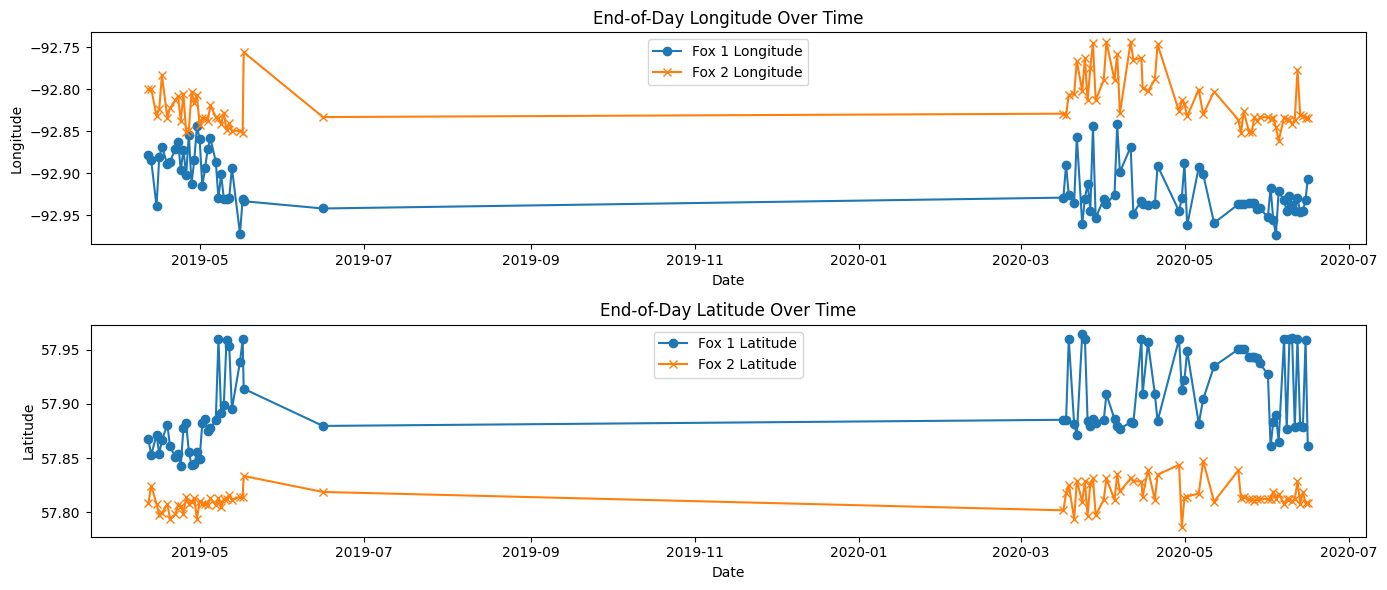

{'pearson_corr_long': 0.22513747746930515, 'pearson_corr_lat': 0.29204460885128325}


In [69]:
def analyze_fox_correlation_end_of_day(df1, df2):
    """
    Analyze the correlation between the movement patterns of two foxes based on longitude and latitude,
    using only the location at the end of each day.

    Parameters:
        df1 (pd.DataFrame): DataFrame with 'timestamp', 'location-long', and 'location-lat' for Fox 1.
        df2 (pd.DataFrame): DataFrame with 'timestamp', 'location-long', and 'location-lat' for Fox 2.

    Returns:
        dict: Pearson correlations for longitude and latitude after alignment.
    """
    # Convert timestamps to datetime objects
    df1['timestamp'] = pd.to_datetime(df1['timestamp'])
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])

    # Group by date and select the last record for each day
    df1_end_of_day = df1.groupby(df1['timestamp'].dt.date).last().reset_index(drop=True)
    df2_end_of_day = df2.groupby(df2['timestamp'].dt.date).last().reset_index(drop=True)

    # Merge DataFrames on timestamp
    merged_df = pd.merge(df1_end_of_day, df2_end_of_day, on='timestamp', suffixes=('_fox1', '_fox2'))
    
    # Extract aligned data
    time = pd.to_datetime(merged_df['timestamp'])
    fox1_long = merged_df['location-long_fox1'].values
    fox1_lat = merged_df['location-lat_fox1'].values
    fox2_long = merged_df['location-long_fox2'].values
    fox2_lat = merged_df['location-lat_fox2'].values

    # Pearson correlation for longitude and latitude
    corr_long, _ = pearsonr(fox1_long, fox2_long)
    corr_lat, _ = pearsonr(fox1_lat, fox2_lat)

    # Plot aligned end-of-day trajectories
    plt.figure(figsize=(14, 6))
    
    # Longitude comparison
    plt.subplot(2, 1, 1)
    plt.plot(time, fox1_long, label='Fox 1 Longitude', marker='o')
    plt.plot(time, fox2_long, label='Fox 2 Longitude', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Longitude')
    plt.title('End-of-Day Longitude Over Time')
    plt.legend()

    # Latitude comparison
    plt.subplot(2, 1, 2)
    plt.plot(time, fox1_lat, label='Fox 1 Latitude', marker='o')
    plt.plot(time, fox2_lat, label='Fox 2 Latitude', marker='x')
    plt.xlabel('Date')
    plt.ylabel('Latitude')
    plt.title('End-of-Day Latitude Over Time')
    plt.legend()

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Return Pearson correlation results
    return {
        'pearson_corr_long': corr_long,
        'pearson_corr_lat': corr_lat,
    }


# Example usage
# Assuming `fox1_df` and `fox2_df` are your DataFrames with 'timestamp', 'location-lat', and 'location-long'
end_of_day_correlation = analyze_fox_correlation_end_of_day(red_fox_F701533, red_fox_F701532)
print(end_of_day_correlation)


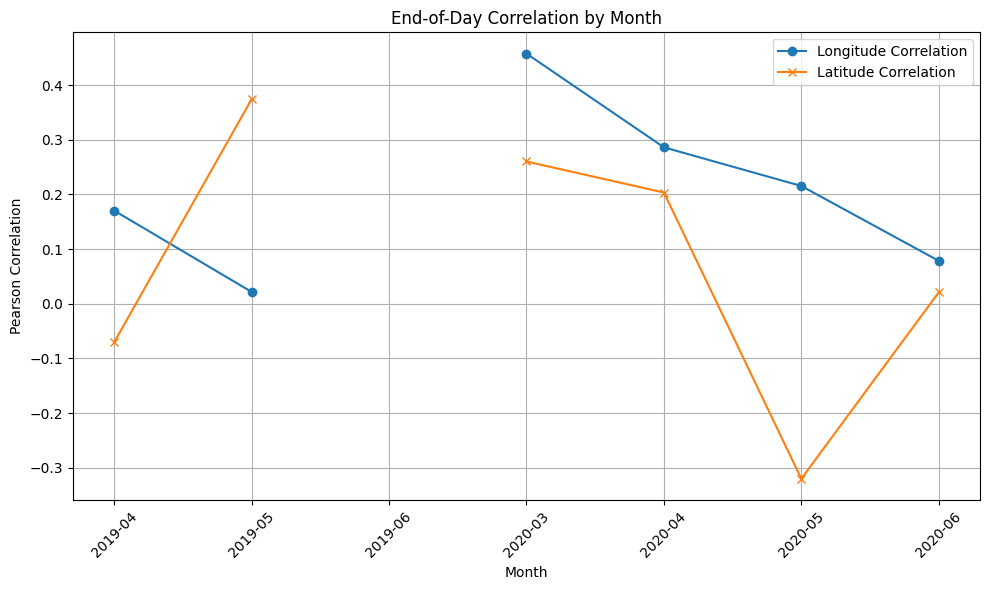

     month  pearson_corr_long  pearson_corr_lat
0  2019-04           0.170379         -0.070514
1  2019-05           0.021687          0.373904
2  2019-06                NaN               NaN
3  2020-03           0.457513          0.260164
4  2020-04           0.286090          0.203367
5  2020-05           0.215382         -0.320020
6  2020-06           0.078440          0.020964


In [72]:
def analyze_fox_correlation_end_of_day_by_month(df1, df2):
    """
    Analyze the correlation between the movement patterns of two foxes based on longitude and latitude,
    using only the location at the end of each day and grouping by month.

    Parameters:
        df1 (pd.DataFrame): DataFrame with 'timestamp', 'location-long', and 'location-lat' for Fox 1.
        df2 (pd.DataFrame): DataFrame with 'timestamp', 'location-long', and 'location-lat' for Fox 2.

    Returns:
        pd.DataFrame: Correlation results (longitude and latitude) grouped by month.
    """
    # Convert timestamps to datetime objects
    df1['timestamp'] = pd.to_datetime(df1['timestamp'])
    df2['timestamp'] = pd.to_datetime(df2['timestamp'])

    # Group by date and select the last record for each day
    df1_end_of_day = df1.groupby(df1['timestamp'].dt.date).last().reset_index(drop=True)
    df2_end_of_day = df2.groupby(df2['timestamp'].dt.date).last().reset_index(drop=True)

    # Add a month column for grouping
    df1_end_of_day['month'] = df1_end_of_day['timestamp'].dt.to_period('M')
    df2_end_of_day['month'] = df2_end_of_day['timestamp'].dt.to_period('M')

    # Merge the end-of-day DataFrames
    merged_df = pd.merge(
        df1_end_of_day,
        df2_end_of_day,
        on='timestamp',
        suffixes=('_fox1', '_fox2')
    )

    # Add a month column to the merged DataFrame
    merged_df['month'] = merged_df['timestamp'].dt.to_period('M')

    # Group by month and calculate Pearson correlations
    results = []
    for month, group in merged_df.groupby('month'):
        fox1_long = group['location-long_fox1'].values
        fox1_lat = group['location-lat_fox1'].values
        fox2_long = group['location-long_fox2'].values
        fox2_lat = group['location-lat_fox2'].values

        # Ensure there are at least two data points for correlation
        if len(fox1_long) > 1:
            corr_long, _ = pearsonr(fox1_long, fox2_long)
            corr_lat, _ = pearsonr(fox1_lat, fox2_lat)
        else:
            corr_long, corr_lat = np.nan, np.nan  # Not enough data for correlation

        results.append({'month': month, 'pearson_corr_long': corr_long, 'pearson_corr_lat': corr_lat})

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)

    # Plot correlations by month
    plt.figure(figsize=(10, 6))
    plt.plot(results_df['month'].astype(str), results_df['pearson_corr_long'], label='Longitude Correlation', marker='o')
    plt.plot(results_df['month'].astype(str), results_df['pearson_corr_lat'], label='Latitude Correlation', marker='x')
    plt.xlabel('Month')
    plt.ylabel('Pearson Correlation')
    plt.title('End-of-Day Correlation by Month')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return results_df




# Example usage
# Assuming `fox1_df` and `fox2_df` are your DataFrames with 'timestamp', 'location-lat', and 'location-long'
monthly_correlation = analyze_fox_correlation_end_of_day_by_month(red_fox_F701533, red_fox_F701532)
print(monthly_correlation)